# Oil Wells Profit Prediction 
---

The project task is to find the most profitable place for OilyGiant's new well. Three regions will be examined. The following steps will be taken:
- Collect the oil well parameters in the selected region: oil quality and volume of reserves
- Build a model for predicting the volume of reserves in the new wells
- Pick the oil wells with the highest estimated values
- Pick the region with the highest total profit for the selected oil wells

### Part One: Prepare the Data
---

In [1]:
# Install Necessary Packages 

# Data Prep Packages 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import random

# Model 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Model Assessment Package 
from sklearn.metrics import  mean_squared_error

# Visualization package 
import matplotlib.pyplot as plt

In [2]:
# Read in the data 
try:
    # Attempt to read the data
    r0 = pd.read_csv('datasets/geo_data_0.csv')
    r1 = pd.read_csv('datasets/geo_data_1.csv')
    r2 = pd.read_csv('datasets/geo_data_2.csv')
    # If successful, print Confirmation
    print("The data has been read in as r0, r1, and r2.")
except Exception as e:
    # If an error occurs, print an error message
    print("Error reading data:", e)
    print("To get the data sets please visit: https://github.com/le-crupi64/Oil-Well-Profit-Prediction")

The data has been read in as r0, r1, and r2.


#### Check for any data cleanliness issues

In [3]:
r0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
r1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
# Check for duplicated rows and ids 
# Region 0
print("Duplicated rows in r0: ", r0.duplicated().sum())
print("Duplicated ids in r0: ", r0['id'].duplicated().sum())

# Region 1
print("Duplicated rows in r1: ", r1.duplicated().sum())
print("Duplicated ids in r1: ", r1['id'].duplicated().sum())

# Region 2
print("Duplicated rows in r2: ", r2.duplicated().sum())
print("Duplicated ids in r2: ", r2['id'].duplicated().sum())

Duplicated rows in r0:  0
Duplicated ids in r0:  10
Duplicated rows in r1:  0
Duplicated ids in r1:  4
Duplicated rows in r2:  0
Duplicated ids in r2:  4


**Data Cleanliness Findings**
- All three data sets have no null values and all columns are in the appropriate data type
- All three data sets have duplicates in the id column, but the rows have unique features. 

Corrective Action: Leave the rows but drop the id column, as it can not be passed into the linear regression model

#### Statistical Data Analysis 

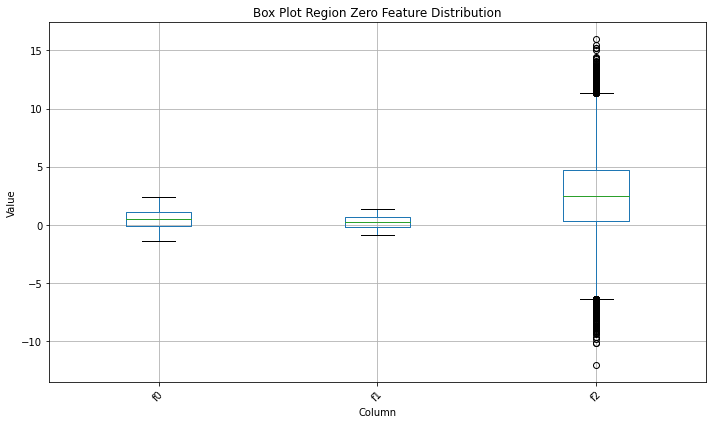

In [7]:
# Create a Box Plot for Region Zero Features 
columns_to_plot = ['f0', 'f1', 'f2']

# Extract data for the specified columns
data_to_plot = r0[columns_to_plot]

# Create a box plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
data_to_plot.boxplot()

# Customize plot
plt.title('Box Plot Region Zero Feature Distribution')
plt.ylabel('Value')
plt.xlabel('Column')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

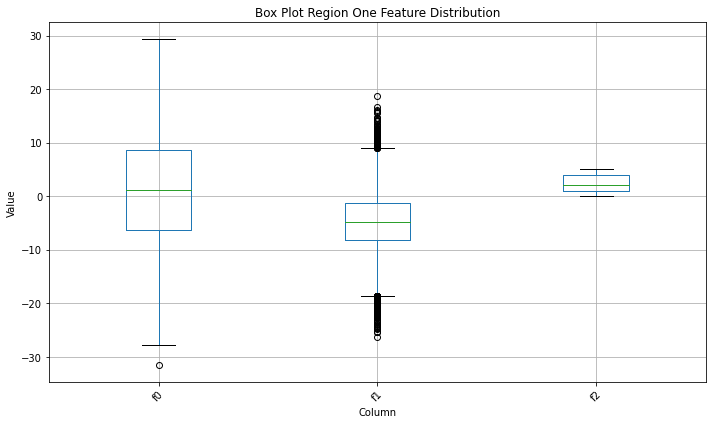

In [8]:
# Create a Box Plot for Region one Features 
columns_to_plot = ['f0', 'f1', 'f2']

# Extract data for the specified columns
data_to_plot = r1[columns_to_plot]

# Create a box plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
data_to_plot.boxplot()

# Customize plot
plt.title('Box Plot Region One Feature Distribution')
plt.ylabel('Value')
plt.xlabel('Column')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

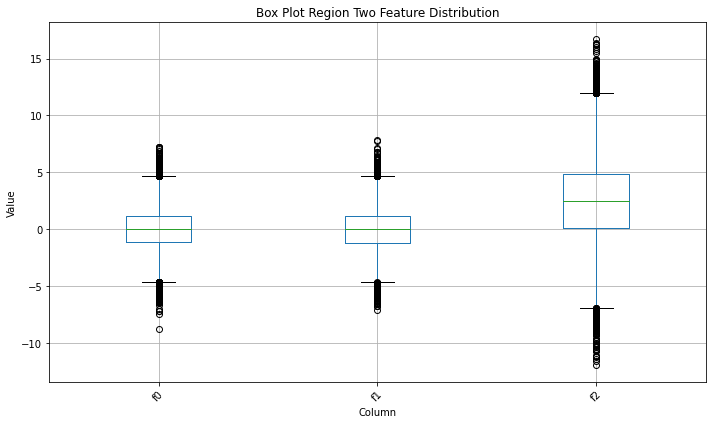

In [9]:
# Create a Box Plot for Region Two Features 
columns_to_plot = ['f0', 'f1', 'f2']

# Extract data for the specified columns
data_to_plot = r2[columns_to_plot]

# Create a box plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
data_to_plot.boxplot()

# Customize plot
plt.title('Box Plot Region Two Feature Distribution')
plt.ylabel('Value')
plt.xlabel('Column')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

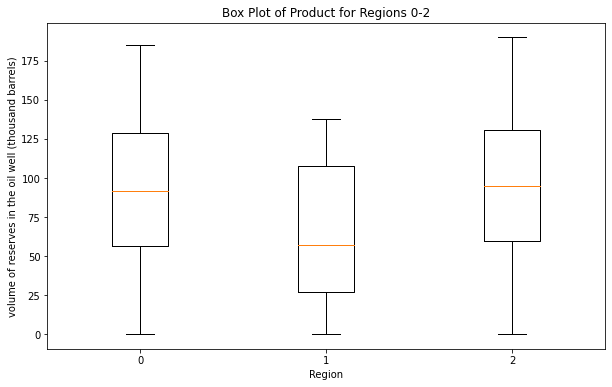

In [10]:
# Create a box plot for each separate column
plt.figure(figsize=(10, 6))
plt.boxplot([r0['product'], r1['product'], r2['product']])
plt.title('Box Plot of Product for Regions 0-2')
plt.ylabel('volume of reserves in the oil well (thousand barrels)')
plt.xlabel('Region')
plt.xticks([1, 2, 3], ['0', '1', '2'])
plt.show()

**Findings:** 
Due to the difference in the scale of the various features for all three data sets, the data should be scaled. Region 2 has the most variability, region 1 has the least. 

#### Splitting the Data 

**Prepare the Region Zero Data Set**

In [11]:
# Split the r0 data set into features and target
target = r0['product']
features = r0.drop('product', axis = 1)

# Initialize standard Scaler for Region 0 data
scaler0 = StandardScaler()

In [12]:
# Split into training and validation sets
r0_features_train, r0_features_valid, r0_target_train, r0_target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

#Split off ID
r0_features_train = r0_features_train.drop('id', axis=1)
r0_valid_ids= r0_features_valid['id']
r0_features_valid = r0_features_valid.drop('id', axis=1)

#Scale features
r0_features_train =scaler0.fit_transform(r0_features_train)
r0_features_valid =scaler0.transform(r0_features_valid)

# Check Set shapes 
print('features_train size: ', r0_features_train.shape)
print('target_train size: ', r0_target_train.shape)
print('features_valid size: ', r0_features_valid.shape)
print('target_valid size: ', r0_target_valid.shape)

features_train size:  (75000, 3)
target_train size:  (75000,)
features_valid size:  (25000, 3)
target_valid size:  (25000,)


**Prepare the Region One Data Set**

In [13]:
# Split the r1 data set into features and target
target = r1['product']
features = r1.drop('product', axis = 1)

# Initialize standard Scaler for Region 1 data
scaler1 = StandardScaler()

In [14]:
# Split into training and validation sets
r1_features_train, r1_features_valid, r1_target_train, r1_target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

#Split off ID
r1_features_train = r1_features_train.drop('id', axis=1)
r1_valid_ids= r1_features_valid['id']
r1_features_valid = r1_features_valid.drop('id', axis=1)

# Scale Features
r1_features_train =scaler1.fit_transform(r1_features_train)
r1_features_valid =scaler1.transform(r1_features_valid)

# Check Set shapes 
print('features_train size: ', r1_features_train.shape)
print('target_train size: ', r1_target_train.shape)
print('features_valid size: ', r1_features_valid.shape)
print('target_valid size: ', r1_target_valid.shape)

features_train size:  (75000, 3)
target_train size:  (75000,)
features_valid size:  (25000, 3)
target_valid size:  (25000,)


**Prepare the Region Two Data Set**

In [15]:
# Split the r1 data set into features and target
target = r2['product']
features = r2.drop('product', axis = 1)

# Initialize standard Scaler for Region 2 data
scaler2 = StandardScaler()

In [16]:
# Split into training and validation sets
r2_features_train, r2_features_valid, r2_target_train, r2_target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

#Split off ID
r2_features_train = r2_features_train.drop('id', axis=1)
r2_valid_ids= r2_features_valid['id']
r2_features_valid = r2_features_valid.drop('id', axis=1)

#Scale features
r2_features_train =scaler2.fit_transform(r2_features_train)
r2_features_valid =scaler2.transform(r2_features_valid)

# Check Set shapes 
print('features_train size: ', r2_features_train.shape)
print('target_train size: ', r2_target_train.shape)
print('features_valid size: ', r2_features_valid.shape)
print('target_valid size: ', r2_target_valid.shape)

features_train size:  (75000, 3)
target_train size:  (75000,)
features_valid size:  (25000, 3)
target_valid size:  (25000,)


### Part Two: Train the Model and Make Predictions for Each Region 
---

#### Region Zero 

In [17]:

# Define a range of alpha values to search
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Perform grid search with cross-validation
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
grid_search.fit(r0_features_train, r0_target_train)

# Get the best Ridge regression model from grid search
best_ridge_model = grid_search.best_estimator_

# Make predictions on the validation data using the best model
r0_predictions = best_ridge_model.predict(r0_features_valid)

# Calculate RMSE
mse = mean_squared_error(r0_target_valid, r0_predictions)
r0_rmse = np.sqrt(mse)

print('Average Volume of Predicted Reserves for Region 0: ', r0_predictions.mean())
print("Model RMSE: ", r0_rmse)

Average Volume of Predicted Reserves for Region 0:  92.59257977266688
Model RMSE:  37.57943663534942


#### Region One

In [18]:
r1_model = LinearRegression()

r1_model.fit(r1_features_train, r1_target_train)

r1_predictions = r1_model.predict(r1_features_valid)

# Calculate the RMSE
mse = mean_squared_error(r1_target_valid, r1_predictions)
r1_rmse = np.sqrt(mse)

print('Average Volume of Predicted Reserves for Region One: ', r1_predictions.mean())
print("Model RMSE: ", r1_rmse)

Average Volume of Predicted Reserves for Region One:  68.728546895446
Model RMSE:  0.893099286775617


#### Region Two

In [19]:
r2_model = LinearRegression()

r2_model.fit(r2_features_train, r2_target_train)

r2_predictions = r2_model.predict(r2_features_valid)

# Calculate the RMSE
mse = mean_squared_error(r2_target_valid, r2_predictions)
r2_rmse = np.sqrt(mse)

print('Average Volume of Predicted Reserves for Region One: ', r2_predictions.mean())
print("Model RMSE: ", r2_rmse)

Average Volume of Predicted Reserves for Region One:  94.96504596800489
Model RMSE:  40.02970873393434


**Analysis**

Regions 0 and one have a higher average volume of predicted reserves, with approximately 92.6 and 94.9 respectively. That being said that the models also have a higher RMSE, with approximately 37.6 and 40.0 respectively. Meanwhile, region 1 has an average volume of predicted reserves of approximately 68.7 and a model RMSE of approximately 0.89. This suggests that the model predicts reserves much more accurately for the region one data. It can be observed in the statistical analysis done earlier that the features of the region one data have a different distribution than those of the other two regions, and the product values have less variability. 

### Part Three: Profit Calculations
---

The projected profit of each region will be calculated by selecting the 200 wells with the highest predicted volume and determining their profit using the following conditions: 
- The budget for development of 200 oil wells is 100 USD million.
- One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).

**Calculate the volume of reserves sufficient for developing a new well without losses**

In [20]:
well_min = (100000000/200)/4500 # (Development cost / number of wells) / revenue per one thousand barrels
print("To break even on 200 wells, each well must have ", well_min, "thousand barrels of oil")
print("or the 200 wells must average to at least that amount")

To break even on 200 wells, each well must have  111.11111111111111 thousand barrels of oil
or the 200 wells must average to at least that amount


**Compare the obtained value with the average volume of reserves in each region**

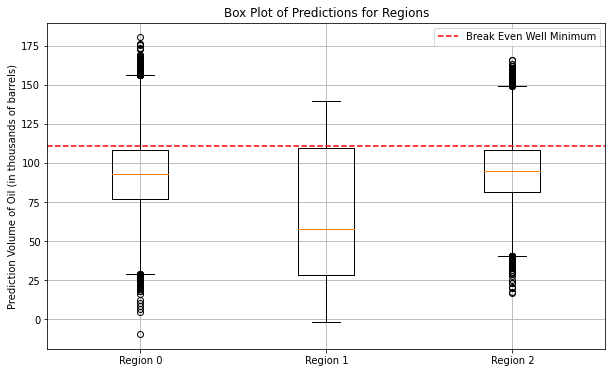

In [21]:

plt.figure(figsize=(10, 6))
plt.boxplot([r0_predictions, r1_predictions, r2_predictions])
plt.title('Box Plot of Predictions for Regions')
plt.ylabel('Prediction Volume of Oil (in thousands of barrels)')
plt.xticks([1, 2, 3], ['Region 0', 'Region 1', 'Region 2'])
plt.grid(True) # Add grid lines for better visualization
plt.axhline(y=well_min, color='r', linestyle='--', label='Break Even Well Minimum')


plt.legend()
plt.show()

In [22]:
print("The predicted average for region 0 is ", well_min-r0_predictions.mean(),"thousand barrels less than the profitable minimum.")
print("The predicted average for region 1 is ", well_min-r1_predictions.mean(),"thousand barrels less than the profitable minimum.")
print("The predicted average for region 2 is ", well_min-r2_predictions.mean(),"thousand barrels less than the profitable minimum.")

The predicted average for region 0 is  18.518531338444234 thousand barrels less than the profitable minimum.
The predicted average for region 1 is  42.38256421566511 thousand barrels less than the profitable minimum.
The predicted average for region 2 is  16.146065143106227 thousand barrels less than the profitable minimum.


**Findings**

The average and majority of wells for each region do not meet the 111 thousand barrel threshold of profitability. Region one falls the most short, with its predicted average being approximately 42 thousand barrels less than the profitable minimum, while regions 0 and 2 fall significantly less short, with their predicted averages short by 18.5 and 16.1 thousand barrels respectively. 

**Calculate profit from a set of selected oil wells and model predictions**

In [23]:
def complete_df(targets, predictions, ids):
    df = pd.DataFrame({
    'actual': targets,
    'prediction': predictions,
    'id': ids})
    return df

In [24]:
def profit(df):
    df = df.sort_values(by='prediction',ascending=False)
    top_wells = df.head(200)
    profit = (top_wells['actual'].sum() * 4500) - 100000000
    return profit

In [25]:
r0_data = complete_df(r0_target_valid,r0_predictions, r0_valid_ids)
r1_data = complete_df(r1_target_valid,r1_predictions, r1_valid_ids)
r2_data = complete_df(r2_target_valid,r2_predictions, r2_valid_ids)

print("Potential profit for region zero wells: ", profit(r0_data))
print("Potential profit for region one wells: ", profit(r1_data))
print("Potential profit for region two wells: ", profit(r2_data))

Potential profit for region zero wells:  33208260.43139851
Potential profit for region one wells:  24150866.966815114
Potential profit for region two wells:  27103499.635998324


**Findings**

*Without considering risk*, it is clear that region zer0 has the highest predicted profit, with an estimation of approximately 33,208,260.43 USD. That is approximately 6 million USD more profit than region 2 and approximately 9 million USD more profitable than region 1. 

### Part Four: Calculate Risks and Profit for Each Region
---

The bootstrapping technique will be used to find the distribution of profit. Average profit, 95% confidence interval and risk of losses will also be calculated for each region. 

In [26]:
r0_data.shape


(25000, 3)

In [28]:
# Bootstrap the predictions from the three regions 
state = np.random.RandomState(12345)
num_samples = 1000
sample_size= 500

# Bootstrap the predictions from Region O
r0_profit_bootstrap = []
for i in range(num_samples):
    sample = r0_data.sample(frac=sample_size/len(r0_data), replace=True, random_state=state)
    sample_profit = profit(sample)
    r0_profit_bootstrap.append(sample_profit)

# Bootstrap the predictions from Region 1
r1_profit_bootstrap = []
for i in range(num_samples):
    sample = r1_data.sample(frac=sample_size/len(r1_data), replace=True, random_state=state)
    sample_profit = profit(sample)
    r1_profit_bootstrap.append(sample_profit)
    
# Bootstrap the predictions from Region 2
r2_profit_bootstrap = []
for i in range(num_samples):
    sample = r2_data.sample(frac=sample_size/len(r2_data), replace=True, random_state=state)
    sample_profit = profit(sample)
    r2_profit_bootstrap.append(sample_profit)

In [29]:
def calculate(profits):
    
    # Calculate average profit 
    avg_profit = np.mean(profits)
    # Calculate 95% confidence interval 
    ci= np.percentile(profits, [2.5, 97.5])
     # Calculate risk of losses (probability of negative profit)
    count = 0
    for profit in profits:
        if profit < 0:
            count +=1 
    risk = count/len(profits)

    # Express risk of losses as a percentage
    risk_percentage = risk * 100

    return avg_profit, ci, risk, risk_percentage

In [30]:
avg_profit_0, ci_0, risk_0, risk_percentage_0 = calculate(r0_profit_bootstrap)
print("Region 0")
print("Average Profit:", avg_profit_0)
print("95% Confidence Interval:", ci_0)
print("Risk of Losses:", risk_0)
print(f"Risk Percentage: {risk_percentage_0:.2f}%")

Region 0
Average Profit: 3960965.058239498
95% Confidence Interval: [-1112155.45890496  9097669.41553423]
Risk of Losses: 0.069
Risk Percentage: 6.90%


In [31]:
avg_profit_1, ci_1, risk_1, risk_percentage_1 = calculate(r1_profit_bootstrap)
print("Region 1")
print("Average Profit:", avg_profit_1)
print("95% Confidence Interval:", ci_1)
print("Risk of Losses:", risk_1)
print(f"Risk Percentage: {risk_percentage_1:.2f}%")

Region 1
Average Profit: 4611558.172772396
95% Confidence Interval: [ 780508.10751742 8629520.60263723]
Risk of Losses: 0.007
Risk Percentage: 0.70%


In [32]:
avg_profit_2, ci_2, risk_2, risk_percentage_2 = calculate(r2_profit_bootstrap)
print("Region 2")
print("Average Profit:", avg_profit_2)
print("95% Confidence Interval:", ci_2)
print("Risk of Losses:", risk_2)
print(f"Risk Percentage: {risk_percentage_2:.2f}%")

Region 2
Average Profit: 3929504.7517060456
95% Confidence Interval: [-1122276.25378575  9345629.14551164]
Risk of Losses: 0.065
Risk Percentage: 6.50%


**Findings**

Region 1 offers the lowest risk, with only a 0.7% risk of loss, and the highest average profit. 

### Final Recommendations 
---

Based on the analysis of profits and associated risks in different regions, it is recommended to set up wells in Region 1. The findings indicate that Region 1 has the highest average profit among the three regions, with an average profit of \\$4,611,572. Furthermore, the 95% confidence interval for profits in Region 1 ranges from \\$780,508 to \\$8,629,521, suggesting relatively stable returns. Additionally, Region 1 exhibits the lowest risk of losses, with only a 0.7% chance of experiencing losses, compared to 7% in Region 0 and 6.5% in Region 2. These favorable indicators in Region 1 make it a promising choice for well establishment, offering a potentially lucrative opportunity with relatively low risk.